# TF-IDF (Term Frequency-Inverse Document Frequency)

## BoW 的問題
純粹的詞袋模型 (BoW) 只計算詞頻，但有些詞（如「電影」）在很多文檔中都出現，區分度低；
而有些詞（如「機器學習」）雖然出現次數少，但對於識別文檔主題非常重要。

## TF-IDF 的解決方案
- **TF (Term Frequency)**：詞在當前文檔中的頻率
- **IDF (Inverse Document Frequency)**：降低常見詞的權重，提高稀有詞的權重
- **TF-IDF = TF × IDF**

In [1]:
import warnings

warnings.filterwarnings("ignore", category=SyntaxWarning, module="jieba")
warnings.filterwarnings("ignore", message="pkg_resources is deprecated")

import jieba
import numpy as np
import pandas as pd
import platform
import matplotlib.pyplot as plt
import seaborn as sns

# 設置中文字體
if platform.system() == 'Darwin':
    plt.rcParams['font.sans-serif'] = ['Heiti TC', 'PingFang HK', 'Arial Unicode MS']
else:
    plt.rcParams['font.sans-serif'] = ['SimHei', 'WenQuanYi Micro Hei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# ==========================================
# 測試語料庫：設計來展示 TF-IDF 的優勢
# ==========================================
# 設計重點：
# - "電影" 出現在 5/7 個文檔（常見詞，IDF 低）
# - "機器學習"、"神經網路" 只出現在 2 個文檔（稀有但重要，IDF 高）
# - 預期：TF-IDF 會降低「電影」的權重，提升 AI 專業術語的權重

corpus = [
    "我喜歡看電影週末常去電影院",             # 0: 電影
    "這部電影真的很精彩好看",                 # 1: 電影
    "今天和朋友一起去看電影",                 # 2: 電影
    "電影票太貴了但電影很值得",               # 3: 電影
    "機器學習可以訓練神經網路模型",            # 4: AI (機器學習 + 神經網路)
    "深度學習是神經網路的進階應用",            # 5: AI (深度學習 + 神經網路)
    "最近迷上看電影每天都看",                 # 6: 電影
]

stop_words = {'的', '是', '了', '真', '很', '去', '都', '一部', '這部', '和', '也', '在', '可以', '太'}

print("語料庫內容：")
for i, doc in enumerate(corpus):
    tag = "電影" if i in [0,1,2,3,6] else "AI"
    print(f"  文檔 {i} [{tag}]: {doc}")

語料庫內容：
  文檔 0 [電影]: 我喜歡看電影週末常去電影院
  文檔 1 [電影]: 這部電影真的很精彩好看
  文檔 2 [電影]: 今天和朋友一起去看電影
  文檔 3 [電影]: 電影票太貴了但電影很值得
  文檔 4 [AI]: 機器學習可以訓練神經網路模型
  文檔 5 [AI]: 深度學習是神經網路的進階應用
  文檔 6 [電影]: 最近迷上看電影每天都看


In [3]:
# ==========================================
# 分詞處理
# ==========================================

# 添加自定義詞彙（確保專業術語被正確識別）
jieba.add_word('機器學習')
jieba.add_word('神經網路')
jieba.add_word('深度學習')
jieba.add_word('人工智能')
jieba.add_word('電影院')
jieba.add_word('電影票')
jieba.add_word('進階應用')

def tokenize_corpus(corpus, stop_words):
    """分詞並過濾停用詞"""
    tokenized = []
    for doc in corpus:
        words = jieba.cut(doc)
        filtered = [w for w in words if w not in stop_words and w.strip()]
        tokenized.append(filtered)
    return tokenized

def build_vocabulary(tokenized_docs):
    """建立詞彙表"""
    vocab = []
    for words in tokenized_docs:
        for w in words:
            if w not in vocab:
                vocab.append(w)
    return vocab

tokenized = tokenize_corpus(corpus, stop_words)
vocab = build_vocabulary(tokenized)

print("=== 分詞結果 ===")
for i, tokens in enumerate(tokenized):
    print(f"文檔 {i}: {tokens}")

print(f"\n詞彙表大小: {len(vocab)}")
print(f"詞彙表: {vocab}")

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/7_/dcqrds0d22v6xnh4k3t4zq940000gn/T/jieba.cache
Loading model cost 0.439 seconds.
Prefix dict has been built successfully.


=== 分詞結果 ===
文檔 0: ['我', '喜歡', '看', '電影', '週末常', '電影院']
文檔 1: ['電影', '真的', '精彩', '好看']
文檔 2: ['今天', '朋友', '一起', '看', '電影']
文檔 3: ['電影票', '太貴', '但', '電影', '值得']
文檔 4: ['機器學習', '訓練', '神經網路', '模型']
文檔 5: ['深度學習', '神經網路', '進階應用']
文檔 6: ['最近', '迷上', '看', '電影', '每天', '看']

詞彙表大小: 25
詞彙表: ['我', '喜歡', '看', '電影', '週末常', '電影院', '真的', '精彩', '好看', '今天', '朋友', '一起', '電影票', '太貴', '但', '值得', '機器學習', '訓練', '神經網路', '模型', '深度學習', '進階應用', '最近', '迷上', '每天']


In [4]:
# ==========================================
# BoW 實現 (作為對比基準)
# ==========================================

def compute_bow(tokenized_docs, vocab):
    """計算詞袋向量"""
    n_docs = len(tokenized_docs)
    n_vocab = len(vocab)
    bow_matrix = np.zeros((n_docs, n_vocab))
    
    for i, words in enumerate(tokenized_docs):
        for w in words:
            if w in vocab:
                j = vocab.index(w)
                bow_matrix[i, j] += 1
    
    return bow_matrix

bow_matrix = compute_bow(tokenized, vocab)

print("=== BoW 矩陣 ===")
df_bow = pd.DataFrame(bow_matrix, columns=vocab, index=[f"文檔_{i}" for i in range(len(corpus))])
display(df_bow.style.background_gradient(cmap='Blues', axis=None))

=== BoW 矩陣 ===


,我,喜歡,看,電影,週末常,電影院,真的,精彩,好看,今天,朋友,一起,電影票,太貴,但,值得,機器學習,訓練,神經網路,模型,深度學習,進階應用,最近,迷上,每天
文檔_0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
文檔_1,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
文檔_2,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
文檔_3,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
文檔_4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
文檔_5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
文檔_6,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000


In [5]:
# ==========================================
# TF-IDF 實現
# ==========================================

def compute_tf(tokenized_docs, vocab):
    """
    計算 TF (Term Frequency)
    TF(t, d) = 詞 t 在文檔 d 中出現的次數 / 文檔 d 的總詞數
    """
    n_docs = len(tokenized_docs)
    n_vocab = len(vocab)
    tf_matrix = np.zeros((n_docs, n_vocab))
    
    for i, words in enumerate(tokenized_docs):
        doc_len = len(words)
        if doc_len == 0:
            continue
        for w in words:
            if w in vocab:
                j = vocab.index(w)
                tf_matrix[i, j] += 1
        # 正規化：除以文檔長度
        tf_matrix[i] /= doc_len
    
    return tf_matrix


def compute_idf(tokenized_docs, vocab):
    """
    計算 IDF (Inverse Document Frequency)
    IDF(t) = log(總文檔數 / 包含詞 t 的文檔數) + 1
    
    注意：加 1 是為了避免 IDF 為 0（當詞出現在所有文檔中時）
    """
    n_docs = len(tokenized_docs)
    n_vocab = len(vocab)
    idf = np.zeros(n_vocab)
    
    for j, word in enumerate(vocab):
        # 計算包含這個詞的文檔數
        doc_count = sum(1 for words in tokenized_docs if word in words)
        # IDF 公式（加 1 平滑）
        idf[j] = np.log(n_docs / (doc_count + 1)) + 1
    
    return idf


def compute_tfidf(tokenized_docs, vocab):
    """
    計算 TF-IDF 矩陣
    TF-IDF(t, d) = TF(t, d) × IDF(t)
    """
    tf = compute_tf(tokenized_docs, vocab)
    idf = compute_idf(tokenized_docs, vocab)
    
    # TF-IDF = TF * IDF (廣播乘法)
    tfidf = tf * idf
    
    return tfidf, tf, idf


tfidf_matrix, tf_matrix, idf_vector = compute_tfidf(tokenized, vocab)

print("=== IDF 值（稀有詞的 IDF 更高）===")
df_idf = pd.DataFrame([idf_vector], columns=vocab, index=['IDF'])
display(df_idf.style.background_gradient(cmap='Oranges', axis=1))

=== IDF 值（稀有詞的 IDF 更高）===


,我,喜歡,看,電影,週末常,電影院,真的,精彩,好看,今天,朋友,一起,電影票,太貴,但,值得,機器學習,訓練,神經網路,模型,深度學習,進階應用,最近,迷上,每天
IDF,2.252763,2.252763,1.559616,1.154151,2.252763,2.252763,2.252763,2.252763,2.252763,2.252763,2.252763,2.252763,2.252763,2.252763,2.252763,2.252763,2.252763,2.252763,1.847298,2.252763,2.252763,2.252763,2.252763,2.252763,2.252763


In [6]:
print("=== TF-IDF 矩陣 ===")
df_tfidf = pd.DataFrame(tfidf_matrix, columns=vocab, index=[f"文檔_{i}" for i in range(len(corpus))])
display(df_tfidf.style.background_gradient(cmap='Greens', axis=None).format("{:.3f}"))

=== TF-IDF 矩陣 ===


,我,喜歡,看,電影,週末常,電影院,真的,精彩,好看,今天,朋友,一起,電影票,太貴,但,值得,機器學習,訓練,神經網路,模型,深度學習,進階應用,最近,迷上,每天
文檔_0,0.375,0.375,0.260,0.192,0.375,0.375,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
文檔_1,0.000,0.000,0.000,0.289,0.000,0.000,0.563,0.563,0.563,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
文檔_2,0.000,0.000,0.312,0.231,0.000,0.000,0.000,0.000,0.000,0.451,0.451,0.451,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
文檔_3,0.000,0.000,0.000,0.231,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.451,0.451,0.451,0.451,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
文檔_4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.563,0.563,0.462,0.563,0.000,0.000,0.000,0.000,0.000
文檔_5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.616,0.000,0.751,0.751,0.000,0.000,0.000
文檔_6,0.000,0.000,0.520,0.192,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.375,0.375,0.375


In [7]:
# ==========================================
# 關鍵對比：BoW vs TF-IDF 的詞權重差異
# ==========================================

print("=== 關鍵詞權重對比 ===")
print("\n觀察重點：")
print('- "電影" 在 5/7 個文檔出現 → IDF 較低 → 權重被降低')
print('- "神經網路" 只在 2/7 個文檔出現 → IDF 較高 → 權重被提升')
print()

# 選取關鍵詞來對比
key_words = ['電影', '看', '喜歡', '機器學習', '神經網路', '深度學習']
key_words = [w for w in key_words if w in vocab]

comparison_data = []
for word in key_words:
    idx = vocab.index(word)
    doc_count = sum(1 for words in tokenized if word in words)
    comparison_data.append({
        '詞彙': word,
        '出現文檔數': f"{doc_count}/{len(corpus)}",
        'IDF': f"{idf_vector[idx]:.3f}",
        'BoW總和': f"{bow_matrix[:, idx].sum():.0f}",
        'TF-IDF總和': f"{tfidf_matrix[:, idx].sum():.3f}"
    })

df_comparison = pd.DataFrame(comparison_data)
display(df_comparison)

=== 關鍵詞權重對比 ===

觀察重點：
- "電影" 在 5/7 個文檔出現 → IDF 較低 → 權重被降低
- "神經網路" 只在 2/7 個文檔出現 → IDF 較高 → 權重被提升



,詞彙,出現文檔數,IDF,BoW總和,TF-IDF總和
0,電影,5/7,1.154,5,1.135
1,看,3/7,1.560,4,1.092
2,喜歡,1/7,2.253,1,0.375
3,機器學習,1/7,2.253,1,0.563
4,神經網路,2/7,1.847,2,1.078
5,深度學習,1/7,2.253,1,0.751


In [8]:
# ==========================================
# 餘弦相似度計算
# ==========================================

def cosine_similarity(vec1, vec2):
    """計算餘弦相似度"""
    dot = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0 or norm2 == 0:
        return 0.0
    return dot / (norm1 * norm2)


def compute_similarity_matrix(vectors):
    """計算相似度矩陣"""
    n = len(vectors)
    sim_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            sim_matrix[i, j] = cosine_similarity(vectors[i], vectors[j])
    return sim_matrix


bow_sim = compute_similarity_matrix(bow_matrix)
tfidf_sim = compute_similarity_matrix(tfidf_matrix)

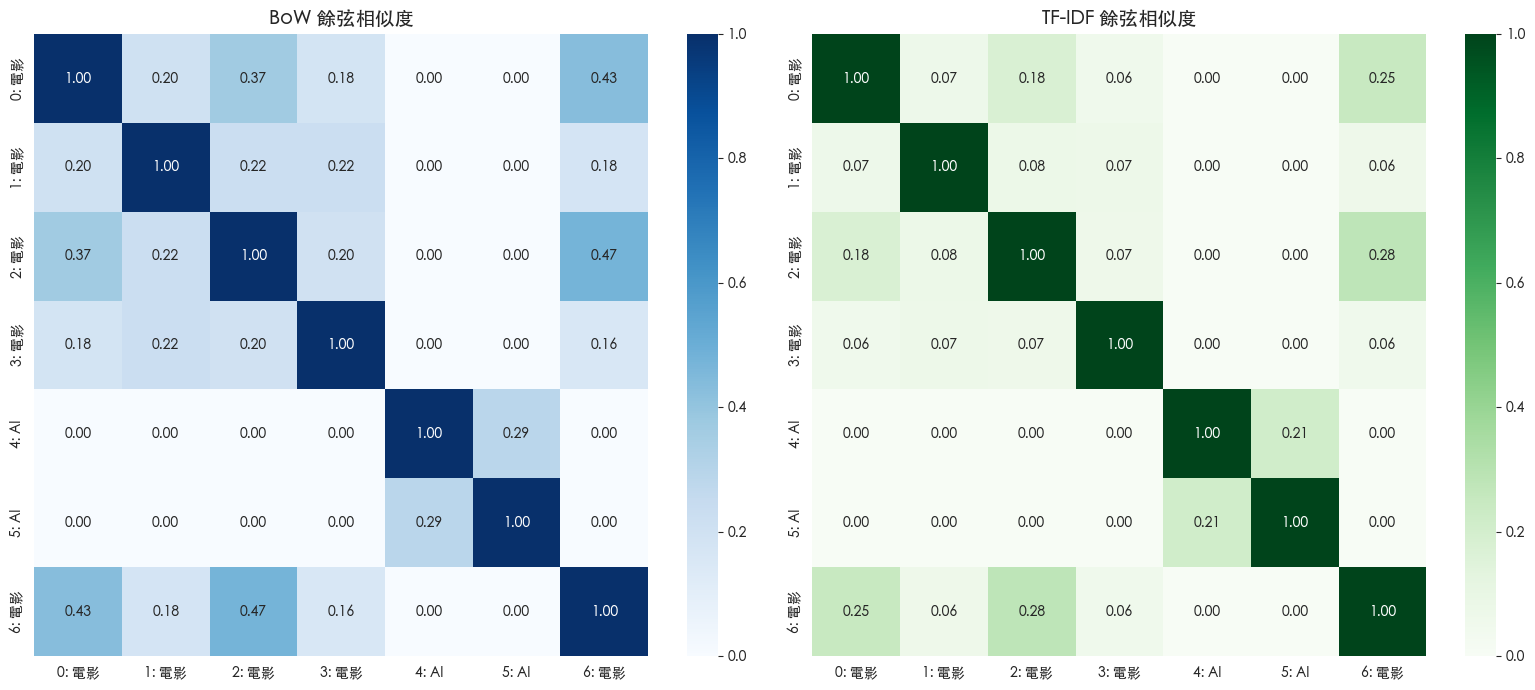

In [9]:
# ==========================================
# 可視化對比
# ==========================================

doc_labels = [
    "0: 電影",
    "1: 電影",
    "2: 電影",
    "3: 電影",
    "4: AI",
    "5: AI",
    "6: 電影"
]

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# BoW 相似度
sns.heatmap(bow_sim, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=doc_labels, yticklabels=doc_labels, ax=axes[0])
axes[0].set_title('BoW 餘弦相似度', fontsize=14)

# TF-IDF 相似度
sns.heatmap(tfidf_sim, annot=True, fmt=".2f", cmap='Greens',
            xticklabels=doc_labels, yticklabels=doc_labels, ax=axes[1])
axes[1].set_title('TF-IDF 餘弦相似度', fontsize=14)

plt.tight_layout()
plt.show()

In [10]:
# ==========================================
# 結果分析
# ==========================================

print("=" * 60)
print("結果分析：TF-IDF vs BoW")
print("=" * 60)

print("\n【AI 文檔之間的相似度】")
print("文檔 4 vs 文檔 5 (共享「神經網路」):")
print(f"  BoW:    {bow_sim[4, 5]:.3f}")
print(f"  TF-IDF: {tfidf_sim[4, 5]:.3f}")

print("\n【電影文檔之間的相似度】")
print("文檔 0 vs 文檔 1:")
print(f"  BoW:    {bow_sim[0, 1]:.3f}")
print(f"  TF-IDF: {tfidf_sim[0, 1]:.3f}")

print("\n文檔 1 vs 文檔 3:")
print(f"  BoW:    {bow_sim[1, 3]:.3f}")
print(f"  TF-IDF: {tfidf_sim[1, 3]:.3f}")

print("\n【跨主題相似度 (應該接近 0)】")
print("文檔 0 (電影) vs 文檔 4 (AI):")
print(f"  BoW:    {bow_sim[0, 4]:.3f}")
print(f"  TF-IDF: {tfidf_sim[0, 4]:.3f}")

print("\n" + "=" * 60)
print("結論")
print("=" * 60)
print("""
1. 「電影」出現在 5/7 個文檔 → IDF 值較低
   - 純 BoW 中，電影文檔因共享「電影」這個高頻詞而有較高相似度
   - TF-IDF 降低了「電影」的權重，減少這種「虛假相似性」

2. 「神經網路」只出現在 2/7 個文檔 → IDF 值較高  
   - AI 文檔共享這個稀有但重要的詞
   - TF-IDF 提升了其權重，AI 文檔間的相似度更能反映主題關聯

3. 核心價值：TF-IDF 解決了「低頻但重要」的問題！
   - 常見詞（如「電影」）對區分文檔貢獻小 → 降權
   - 稀有詞（如「神經網路」）對識別主題很重要 → 提權
""")

結果分析：TF-IDF vs BoW

【AI 文檔之間的相似度】
文檔 4 vs 文檔 5 (共享「神經網路」):
  BoW:    0.289
  TF-IDF: 0.215

【電影文檔之間的相似度】
文檔 0 vs 文檔 1:
  BoW:    0.204
  TF-IDF: 0.067

文檔 1 vs 文檔 3:
  BoW:    0.224
  TF-IDF: 0.070

【跨主題相似度 (應該接近 0)】
文檔 0 (電影) vs 文檔 4 (AI):
  BoW:    0.000
  TF-IDF: 0.000

結論

1. 「電影」出現在 5/7 個文檔 → IDF 值較低
   - 純 BoW 中，電影文檔因共享「電影」這個高頻詞而有較高相似度
   - TF-IDF 降低了「電影」的權重，減少這種「虛假相似性」

2. 「神經網路」只出現在 2/7 個文檔 → IDF 值較高  
   - AI 文檔共享這個稀有但重要的詞
   - TF-IDF 提升了其權重，AI 文檔間的相似度更能反映主題關聯

3. 核心價值：TF-IDF 解決了「低頻但重要」的問題！
   - 常見詞（如「電影」）對區分文檔貢獻小 → 降權
   - 稀有詞（如「神經網路」）對識別主題很重要 → 提權

